## IMPORT LIBARIES


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
import torch

print(torch.cuda.is_available())         # Should print: True
print(torch.cuda.get_device_name(0))     # Prints the name of your assigned GPU


True
Tesla T4


In [34]:

# Load both CSVs
true_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv')

# Add labels: 1 for real, 0 for fake
true_df['label'] = 1
fake_df['label'] = 0

# Combine the data
df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)


In [35]:
df

title  \
0      Woman charged after trying to scale Buckingham...   
1      Germany must stop relying on U.S. for foreign ...   
2      Indonesian police officer killed in shooting n...   
3      Obama confident U.S. will move in right direct...   
4      (VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLI...   
...                                                  ...   
44893  TESTY SHEILA JACKSON LEE Challenges Trump’s Bu...   
44894  Appeals court upholds Ohio law that shortens e...   
44895  Senate leader says has enough votes to change ...   
44896  Zimbabwe army detains finance minister: govern...   
44897  REAL-TIME DEBATE Graph Shows Trump CRUSHED Hil...   

                                                    text       subject  \
0      LONDON (Reuters) - A woman who tried to scale ...     worldnews   
1      BERLIN (Reuters) - Germany should be more asse...     worldnews   
2      JAKARTA/TIMIKA, Indonesia (Reuters) - An Indon...     worldnews   
3      MILAN (Reuters) - Former U.S. President Barack...  politicsNews   
4                                                            left-news   
...                                                  ...           ...   
44893  Mick Mulvaney is one smart cookie. He s doing ...      politics   
44894  (Reuters) - A federal appeals court on Tuesday...  politicsNews   
44895  WASHINGTON (Reuters) - U.S. Senate Majority Le...  politicsNews   
44896  HARARE (Reuters) - Zimbabwe s military detaine...     worldnews   
44897  This unbelievable graph should put the questio...     left-news   

                     date  label  
0        October 8, 2017       1  
1       December 4, 2017       1  
2      November 15, 2017       1  
3            May 9, 2017       1  
4            Apr 27, 2015      0  
...                   ...    ...  
44893        May 24, 2017      0  
44894    August 23, 2016       1  
44895      April 4, 2017       1  
44896  November 15, 2017       1  
44897        Sep 28, 2016      0  

[44898 rows x 5 columns]

In [36]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [37]:
df.describe()

label
count  44898.000000
mean       0.477015
std        0.499477
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [38]:
df.shape

(44898, 5)

In [39]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split


In [40]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)


In [41]:
df['content'] = df['title'] + " " + df['text']


In [42]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42
)


In [43]:
import torch
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Using device: Tesla T4


In [44]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)


In [45]:
import torch
from torch.utils.data import Dataset


In [46]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [47]:
train_dataset = NewsDataset(train_encodings, train_labels.tolist())
val_dataset = NewsDataset(val_encodings, val_labels.tolist())


In [48]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments


In [49]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 119.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [51]:
import transformers
print(transformers.__version__)


4.54.0


In [52]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1
)


In [54]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: junaidkhan99e9 (junaidkhan99e9-company) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

TrainOutput(global_step=4490, training_loss=0.015265385511221457, metrics={'train_runtime': 3659.6316, 'train_samples_per_second': 9.815, 'train_steps_per_second': 1.227, 'total_flos': 9450422886420480.0, 'train_loss': 0.015265385511221457, 'epoch': 1.0})

In [55]:
# Predict using the trainer
predictions_output = trainer.predict(val_dataset)

# Get predicted class labels
preds = predictions_output.predictions.argmax(-1)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4715
        Real       1.00      1.00      1.00      4265

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 0.9999


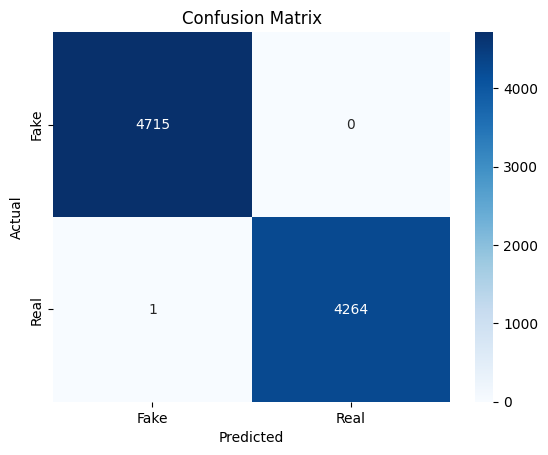

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
print(classification_report(val_labels, preds, target_names=["Fake", "Real"]))

# Accuracy
accuracy = accuracy_score(val_labels, preds)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [57]:
for i in range(5):
    print("TEXT:", val_texts.iloc[i][:300])  # short preview
    print("Actual:", val_labels.iloc[i], "Predicted:", preds[i])
    print("-----")


TEXT: [VIDEO] IOWA STATE FAIR TELLS TRUMP NO LUXURY HELICOPTER RIDES FOR KIDS…Guess Who Found A Way To Give Rides To Kids Anyway? Trump not only found a way around the Iowa State Fair restrictions and followed through on his plan to give kids helicopter rides in his luxury helicopter, he also found a way 
Actual: 0 Predicted: 0
-----
TEXT: REALIST PERSPECTIVE: President Trump, How & Why… 21st Century Wire says Yes, it s true that a string of epic failures on the part of Democrats and the Hillary Clinton campaign contributed to Donald Trump s success in the US Presidential Election, but the real explanation for last week s surprise res
Actual: 0 Predicted: 0
-----
TEXT:  Anti-Gay Texas Attorney General Faces Disbarment The Texas Bar Association is stepping up to the plate to nail Ken Paxton for violating legal ethics.After the Supreme Court ruled same-sex marriage legal across the nation last summer, some red states threw a collective hissy fit over the decision. I
Actual: 0 Predicted: 

In [59]:
pip install shap


In [60]:
import shap
import numpy as np

# Helper: wrap tokenizer + model prediction
def predict_prob(texts):
    tokens = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs[:,1].numpy()  # Probability of class "Real"


In [68]:
import shap
import torch
import numpy as np
from transformers import AutoTokenizer

# Use CPU for SHAP (if GPU gives issues)
device = torch.device("cpu")
model.to(device)
model.eval()

# Reload tokenizer to avoid wandb or memory issues
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [69]:
def predict_prob(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.detach().cpu().numpy()


In [70]:
masker = shap.maskers.Text(tokenizer)  # Now it works!
explainer = shap.Explainer(predict_prob, masker)


In [71]:
sample_texts = val_texts.tolist()[:2]  # Keep it small for testing
shap_values = explainer(sample_texts)


ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [72]:
import shap
import torch
import numpy as np
from transformers import AutoTokenizer

# Solution 1: Check and fix the input format
def check_and_fix_input(texts):
    """Check the format of input texts and fix common issues"""
    print(f"Type of texts: {type(texts)}")
    print(f"Length: {len(texts)}")

    if len(texts) > 0:
        print(f"Type of first element: {type(texts[0])}")
        print(f"First element: {repr(texts[0])}")

    # Fix common issues
    fixed_texts = []
    for text in texts:
        if isinstance(text, (list, tuple)):
            # If it's a list/tuple, join it or take the first element
            if all(isinstance(x, str) for x in text):
                fixed_texts.append(' '.join(text))  # Join tokens
            else:
                fixed_texts.append(str(text[0]) if text else "")
        elif text is None or text == "":
            fixed_texts.append("empty text")  # Handle empty texts
        else:
            fixed_texts.append(str(text))  # Ensure it's a string

    return fixed_texts

# Solution 2: Robust prediction function with error handling
def predict_prob_robust(texts):
    """Robust prediction function with proper error handling"""
    try:
        # Ensure texts is a list of strings
        if isinstance(texts, str):
            texts = [texts]

        # Check and fix input format
        texts = check_and_fix_input(texts)

        # Tokenize
        inputs = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        # Move to device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        return probs.detach().cpu().numpy()

    except Exception as e:
        print(f"Error in prediction: {e}")
        print(f"Input texts type: {type(texts)}")
        if hasattr(texts, '__len__'):
            print(f"Input length: {len(texts)}")
            if len(texts) > 0:
                print(f"First element: {repr(texts[0])}")
        raise

# Solution 3: Safe SHAP setup with debugging
def setup_shap_safely():
    """Setup SHAP with proper error handling and debugging"""

    # Ensure model is on CPU and in eval mode
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    # Reload tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Create masker
    masker = shap.maskers.Text(tokenizer)

    # Create explainer with robust prediction function
    explainer = shap.Explainer(predict_prob_robust, masker)

    return explainer, tokenizer

# Solution 4: Fix your data preparation
def prepare_sample_texts(val_texts, num_samples=2):
    """Properly prepare sample texts for SHAP"""

    # Debug: Check what val_texts actually contains
    print(f"val_texts type: {type(val_texts)}")
    print(f"val_texts shape/length: {getattr(val_texts, 'shape', len(val_texts))}")

    # Different handling based on data type
    if hasattr(val_texts, 'tolist'):  # pandas Series or numpy array
        sample_texts = val_texts.tolist()[:num_samples]
    elif isinstance(val_texts, list):
        sample_texts = val_texts[:num_samples]
    else:
        # Convert to list if it's something else
        sample_texts = list(val_texts)[:num_samples]

    # Ensure all elements are strings
    sample_texts = [str(text) if text is not None else "empty" for text in sample_texts]

    # Debug output
    print(f"Sample texts prepared: {len(sample_texts)} samples")
    for i, text in enumerate(sample_texts):
        print(f"Sample {i}: {type(text)} - {repr(text[:100])}")

    return sample_texts

# Solution 5: Complete fixed implementation
def run_shap_analysis():
    """Complete SHAP analysis with all fixes applied"""

    try:
        # Setup SHAP safely
        explainer, tokenizer = setup_shap_safely()

        # Prepare sample texts properly
        sample_texts = prepare_sample_texts(val_texts, num_samples=2)

        # Run SHAP explanation
        print("Running SHAP explanation...")
        shap_values = explainer(sample_texts)

        print("SHAP analysis completed successfully!")
        return shap_values

    except Exception as e:
        print(f"Error during SHAP analysis: {e}")
        print(f"Error type: {type(e)}")

        # Additional debugging
        if 'sample_texts' in locals():
            print("Sample texts debug info:")
            for i, text in enumerate(sample_texts):
                print(f"  {i}: {type(text)} - {repr(text)}")

        raise

# Alternative Solution 6: Simple text cleaning function
def clean_texts_for_tokenizer(texts):
    """Clean texts to ensure they're in the right format for tokenizer"""

    cleaned_texts = []
    for text in texts:
        if text is None:
            cleaned_texts.append("")
        elif isinstance(text, str):
            cleaned_texts.append(text.strip())
        elif isinstance(text, (list, tuple)):
            # If it's tokenized, join back to string
            if all(isinstance(x, str) for x in text):
                cleaned_texts.append(" ".join(text))
            else:
                cleaned_texts.append(str(text))
        else:
            cleaned_texts.append(str(text))

    return cleaned_texts

# Usage example:
# shap_values = run_shap_analysis()

In [76]:
shap_values = run_shap_analysis()


val_texts type: <class 'pandas.core.series.Series'>
val_texts shape/length: (8980,)
Sample texts prepared: 2 samples
Sample 0: <class 'str'> - '[VIDEO] IOWA STATE FAIR TELLS TRUMP NO LUXURY HELICOPTER RIDES FOR KIDS…Guess Who Found A Way To Giv'
Sample 1: <class 'str'> - 'REALIST PERSPECTIVE: President Trump, How & Why… 21st Century Wire says Yes, it s true that a string'
Running SHAP explanation...
Type of texts: <class 'numpy.ndarray'>
Length: 1
Type of first element: <class 'numpy.str_'>
First element: np.str_('[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Type of texts: <class 'numpy.ndarray'>
Length: 1
Type of first element: <class 'numpy.str_'>
First element: np.str_('[VIDEO] IOWA STATE FAIR TELLS TRUMP NO LUXURY HELICOPTER RIDES FOR KIDS…Guess Who Found A Way To Give Rides To Kids Anyway? Trump not only found a way around the Iowa State Fair restrictions and followed through on his plan to give kids helicopter rides in his luxury helicopter, he also found a way to shut down every gotcha question by the media The GOP frontrunner, who was told last month he could not set up his $7million Sikorsky S-76 helicopter at the Iowa State Fair, hired a nearby parking lot instead. From there he gave free rides to youngsters at his own risk and expense as he had planned to at this weekend s fair.The luxury helicopter on which kids were able to see what cornfields look like from 5,000 feet in the sky was at Des Moines airport on Saturday morning, preparing for its departure to the event.The 52-foot executive chopper which seats 12 people comfortab

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Type of texts: <class 'numpy.ndarray'>
Length: 2
Type of first element: <class 'numpy.str_'>
First element: np.str_('[VIDEO] IOWA STATE FAIR TELLS TRUMP NO LUXURY HELICOPTER RIDES FOR KIDS…Guess Who Found A Way To Give Rides To Kids Anyway? Trump not only found a way around the Iowa State Fair restrictions and followed through on his plan to give kids helicopter rides in his luxury helicopter, he also found a way to shut down every gotcha question by the media The GOP frontrunner, who was told last month he could not set up his $7million Sikorsky S-76 helicopter at the Iowa State Fair, hired a nearby parking lot instead. From there he gave free rides to youngsters at his own risk and expense as he had planned to at this weekend s fair.The luxury helicopter on which kids were able to see what cornfields look like from 5,000 feet in the sky was at Des Moines airport on Saturday morning, preparing for its departure to the event. [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Type of texts: <class 'numpy.ndarray'>
Length: 6
Type of first element: <class 'numpy.str_'>
First element: np.str_('[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [

  0%|          | 0/498 [00:00<?, ?it/s]

Type of texts: <class 'numpy.ndarray'>
Length: 6
Type of first element: <class 'numpy.str_'>
First element: np.str_('[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Type of texts: <class 'numpy.ndarray'>
Length: 1
Type of first element: <class 'numpy.str_'>
First element: np.str_('[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]')
Type o

  0%|          | 0/498 [00:00<?, ?it/s]

Type of texts: <class 'numpy.ndarray'>
Length: 6
Type of first element: <class 'numpy.str_'>
First element: np.str_('[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]but the real explanation for last week s surprise result goes much deeper [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]')
Type of texts: <class 'n

PartitionExplainer explainer: 3it [12:42, 381.46s/it]

SHAP analysis completed successfully!


In [77]:
shap.plots.text(shap_values[0])  # First sample


In [78]:
for i in range(len(shap_values)):
    shap.plots.text(shap_values[i])


In [79]:
import matplotlib.pyplot as plt

for i in range(len(shap_values)):
    shap.plots.text(shap_values[i], display=False)
    plt.savefig(f"shap_explanation_{i}.png")


<Figure size 640x480 with 0 Axes>

In [80]:
model.save_pretrained("saved_model/fake_news_bert")
tokenizer.save_pretrained("saved_model/fake_news_bert")


('saved_model/fake_news_bert/tokenizer_config.json',
 'saved_model/fake_news_bert/special_tokens_map.json',
 'saved_model/fake_news_bert/vocab.txt',
 'saved_model/fake_news_bert/added_tokens.json',
 'saved_model/fake_news_bert/tokenizer.json')

In [81]:
model_path = "saved_model/fake_news_bert"

# Save model and tokenizer
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('saved_model/fake_news_bert/tokenizer_config.json',
 'saved_model/fake_news_bert/special_tokens_map.json',
 'saved_model/fake_news_bert/vocab.txt',
 'saved_model/fake_news_bert/added_tokens.json',
 'saved_model/fake_news_bert/tokenizer.json')

In [82]:
import shutil

# Create a zip file
shutil.make_archive("fake_news_bert", 'zip', model_path)


'/content/fake_news_bert.zip'